# Stash codes

In [5]:
# Remember: use ceh conda environment

%load_ext autoreload
%autoreload

import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import iris.plot as iplt
import warnings
import numpy as np
import pandas as pd

# Not sure these are needed
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

from   libs.plot_maps    import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set variables

For now, I'm removing the variables which I can't find in either apt4 or apt5

In [14]:
# Loading in data from year 2000, ap5)
dir = '../data/UKESM/historic_1/'
dir_poro = '../data/'

outfile = '../data/UKESM/retrieved_codes/'
#years = range(2000,2015)
years = 2000
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
files = []
#for year in years:
for month in months:
    files.append('bc179a.p5' + str(years) + month +'.pp')

print(files)

['bc179a.p52000jan.pp', 'bc179a.p52000feb.pp', 'bc179a.p52000mar.pp', 'bc179a.p52000apr.pp', 'bc179a.p52000may.pp', 'bc179a.p52000jun.pp', 'bc179a.p52000jul.pp', 'bc179a.p52000aug.pp', 'bc179a.p52000sep.pp', 'bc179a.p52000oct.pp', 'bc179a.p52000nov.pp', 'bc179a.p52000dec.pp']


In [6]:
# dir1 = '../data/'
# file = 'bc179a.p41930oct.pp'
# file2 = 'bc179a.p51929oct.pp'
# file3 = 'bc179a.p41929oct.pp'

stash_conFIRE = {'vegcover'           : 'm01s03i317',
                 'alpha'              : 'm01s08i223',
#                'emc'                : 'm01s03i245',
#                'treeCover'          : 'm01s03i317', # same as vegcover
                 'lightning'          : 'm01s50i082',
#                'pasture'            : 'm01s00i458',
#                'population_density' : 'population_density2000-2014.nc',
                 'relative_humidity'  : 'm01s03i245'}
#                'cropland'           : 'm01s00i448'}

# cube list
# list_of_stash_ap4 = []
# list_of_stash_ap5 = []

#cl_ap4 = iris.load(dir1 + file3)
#cl_ap5 = iris.load(dir1 + file2)

#### Checking to see if STASH codes match any in the file
Uncomment last two lines in previous cell to run

In [108]:
#print(c.attributes['STASH'])

# i = 0
# for c5 in cl_ap5:
#     c5 = cl_ap5[i]
#     for name, dat in stash_conFIRE.items():
#         if c5.attributes["STASH"] == dat:
#             print(name + " in ap5")
#     i += 1

# j = 0
# for c4 in cl_ap4:
#     c4 = cl_ap4[j]
#     for name, dat in stash_conFIRE.items():
#         if c4.attributes["STASH"] == dat:
#             print(name + " in ap4")
#     j += 1

vegcover in ap5
lightning in ap5
alpha in ap5
relative_humidity in ap5


## Variable location:

### ap5

* ``vegcover``
* ``treecover``
* ``alpha``
* ``relative_humdity``
* ``lightning``
* `pasture`
* `cropland`

Everything appears to be in apt5, so we're going to focus on just apt5 files for now. The fractional cover (`'m01s03i317'`) consists of 27 different vegetation types. Below is a key to identify the coordinate codes (these can be viewed with `cube.coord('psuedo_level').points`. Similar for alpha, we only want the top level of moisture, so just the first layer has to be extracted.

* `treecover`
   * 101 = Broadlead deciduous tree
   * 102 = Broadlead evergreen tree   
   * 103  =  Broadlead  temperate evergreen tree
   * 201 = Needleleaf deciduous    
   * 202 = Needleleaf evergreen  
* `cropland`
 * 301 = Grass C3 crop    
 * 401 = Grass C4 crop    
* `pasture`
 * 302 = Grass C3 pature    
 * 402 = Grass C4 pasture
* `vegcover` (This includes the list below and all of the above):
 * 501 = Shrub decidious    
 * 502 = Shrub evergreen    
 * 3 = Grass C3 natural
 * 4 = Grass C4 natural  
   
_Note: You'll need to alter all the output cubes to skip the first year of data (in order to make them the same length as alphaMax). You'll also need to change `m + 3` to `m + 11` so it iterates over 12 months, instead of 3. Lines in the script that need this changing will be labelled #xxx._



In [4]:
treecover = [101, 102, 103, 201, 202]
cropland = [301, 401]
pasture = [302, 402]
vegcover = treecover + cropland + pasture + [3, 4, 501, 502]

name_codes = [treecover, cropland, pasture, vegcover]
name = ['treecover', 'cropland', 'pasture', 'vegcover']
for x in range(0, len(name)):
    print(name_codes[x])

[101, 102, 103, 201, 202]
[301, 401]
[302, 402]
[101, 102, 103, 201, 202, 301, 401, 302, 402, 3, 4, 501, 502]


### Retrieving relative_humidity and lightning

The stash code for both relative_humidity lightning only have 3 dimensions, so they don't need to be condensed the same way the other variables do.

In [15]:
stash_l = [ 'lightning', 'relative_humidity']

for l in stash_l:
    stash_constraint = iris.AttributeConstraint(STASH = stash_conFIRE[l])

    # Load all cubes
    aList =[]
    cube_list = iris.cube.CubeList()
    for f in files: 
        dat = iris.load_cube(dir + f, stash_constraint)
        aList.append(dat)
        print(str(f) + ' file loaded')

    # Merge all cubes together
    cube_list = iris.cube.CubeList(aList)
    cubes = cube_list.merge_cube()

    # For skipping the first x months
    #xxx
    cubes = cubes[3:,:,:]

    print(l + ' has been saved')
    out = outfile + l + '2000.nc'
    iris.save(cubes, out)

bc179a.p52000jan.pp file loaded
bc179a.p52000feb.pp file loaded
bc179a.p52000mar.pp file loaded
bc179a.p52000apr.pp file loaded
bc179a.p52000may.pp file loaded
bc179a.p52000jun.pp file loaded
bc179a.p52000jul.pp file loaded
bc179a.p52000aug.pp file loaded
bc179a.p52000sep.pp file loaded
bc179a.p52000oct.pp file loaded
bc179a.p52000nov.pp file loaded
bc179a.p52000dec.pp file loaded
lightning has been saved
bc179a.p52000jan.pp file loaded
bc179a.p52000feb.pp file loaded
bc179a.p52000mar.pp file loaded
bc179a.p52000apr.pp file loaded
bc179a.p52000may.pp file loaded
bc179a.p52000jun.pp file loaded
bc179a.p52000jul.pp file loaded
bc179a.p52000aug.pp file loaded
bc179a.p52000sep.pp file loaded
bc179a.p52000oct.pp file loaded
bc179a.p52000nov.pp file loaded
bc179a.p52000dec.pp file loaded
relative_humidity has been saved


### Retrieving variables from fractional cover 

In [24]:
stash_constraint = iris.AttributeConstraint(STASH = stash_conFIRE['vegcover'])

# Load all cubes
aList =[]
cube_list = iris.cube.CubeList()
for f in files: 
    dat = iris.load_cube(dir + f, stash_constraint)
    aList.append(dat)
    print(str(f) + ' file loaded')

# Merge all cubes together
cube_list = iris.cube.CubeList(aList)
cube_fractional = cube_list.merge_cube() 
    
    
for var_type in range(0,len(name_codes)):
    index = [cube_fractional.coord('pseudo_level').points == x  for x in name_codes[var_type]]
        
    # This combines all the boolean arrays together. True + False = True
    index = np.any(index, axis = 0)
    print('Indices for ' + name[var_type])
    #print(index)
        
    # Extracts just the layers we want and saves
    cube = cube_fractional[:,index]
    
    # For skipping the first x months
    #xxx
    cube = cube[3:,:,:,:].collapsed(['pseudo_level'], iris.analysis.SUM)
    
    out = outfile + name[var_type] + '2000.nc'
    iris.save(cube, out)
    print(name[var_type] + ' has been saved')

bc179a.p52000jan.pp file loaded
bc179a.p52000feb.pp file loaded
bc179a.p52000mar.pp file loaded
bc179a.p52000apr.pp file loaded
bc179a.p52000may.pp file loaded
bc179a.p52000jun.pp file loaded
bc179a.p52000jul.pp file loaded
bc179a.p52000aug.pp file loaded
bc179a.p52000sep.pp file loaded
bc179a.p52000oct.pp file loaded
bc179a.p52000nov.pp file loaded
bc179a.p52000dec.pp file loaded


## AlphaMax and alpha

To create alphaMax, the maximum alpha of the previous 12 months must be divided by the mean alpha of the last 12 months and then 1 must be subtracted from the result:

\begin{equation}
    \frac{\alpha_{max}}{\alpha} -1
\end{equation}

Loading in and extracting top layer for alpha:

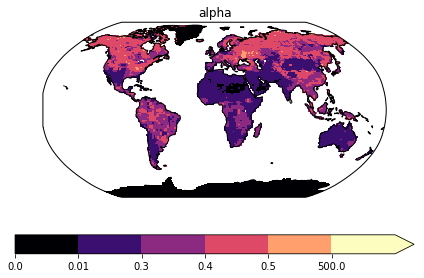

In [157]:
stash_constraint = iris.AttributeConstraint(STASH = stash_conFIRE['alpha'])

# Load all cubes
# aList =[]
# cube_list = iris.cube.CubeList()
# for f in files: 
#     dat = iris.load_cube(dir + f, stash_constraint)
#     aList.append(dat)
#     print(str(f) + ' has loaded')

# Merge all cubes together
cube_list = iris.cube.CubeList(aList)
cube_alpha = cube_list.merge_cube() 

# Extract just the top soil
index_soil = [cube_alpha.coord('depth').points == 0.05]
index_soil = np.any(index_soil, axis = 0) # Still keep this in - it makes the cube happy
cube_soil = cube_alpha[:, index_soil]
cube_soil = cube_soil[:,0,:,:]
cube_soil.long_name = 'alpha'


# Turning soil moisture into alpha: alpha = soil_moisture * soil_porosity * 1.2 (to scale it) / 50 (convert units)
porosity = iris.load(dir_poro + 'qrparm.soil.nc')[5] # 5 = soil porosity
time = len(cube_soil.coord("time").points)
for t in range(time):
    cube_soil.data[t,:,:] = cube_soil.data[t,:,:] * porosity.data * 1.2 / 50

plot_lonely_cube(cube_soil.collapsed('time', iris.analysis.MAX), cmap = 'magma', levels = None)
#xxx
#cube_soil_skip_year = cube_soil[3:,:,:]

# Save alpha
out = outfile + cube_soil.long_name + '2000.nc'
iris.save(cube_soil_skip_year, out)

#### Calculating alphaMax

_Note: when running this on all historical data, the first year must be neglected in order to find alphaMax._

The next section takes the first x (soon to be 12) months of the original cube (cube_soil) and collapses by the mean (cube2) and max (cube3). The alphaMax calculation is then done and the results of which are saved in the alphaMax cube. Note this will have -x timepoints to all the other variables so far.

In [159]:
# Here, we're taking the 3rd time element all the way to the last time point and put it in a new cube
# Note: we're only taking the first 3 months, because I've currently only uploaded a year's worth of data

#xxx
cube2 = cube_soil[3:,:,:]
cube3 = cube_soil[3:,:,:]
alphaMax = cube_soil[3:,:,:]

nmonths = len(cube2.coord("time").points)

#xxx
for m in range( nmonths):
    cube2.data[m,:,:] = cube_soil[m:m+3,:,:].collapsed(["time"], iris.analysis.MEAN).data
    cube3.data[m,:,:] = cube_soil[m:m+3,:,:].collapsed(["time"], iris.analysis.MAX).data
    alphaMax.data[m,:,:] = (cube3.data[m,:,:] / cube2.data[m,:,:]) - 1
    #alphaMax.data[m,:,:] = (cube3[m,:,:].data / cube2[m,:,:].data) - 1 # This does the same thing, I think

In [161]:
alphaMax.long_name = 'alphaMax'

out = outfile + alphaMax.long_name + '2000.nc'
iris.save(alphaMax, out)

alphaMax
